# Regev's algorithm in Qiskit


## note on simulator used
Due to many qbits and  long circuits - currently the code is set up to work with  high performance qiskit-air simulator  

https://github.com/Qiskit/qiskit-aer

Before running the notebook please install:

<code>!pip install qiskit-aer</code>

## Preparations

In [1]:
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit.visualization import plot_histogram

In [2]:
import sys
import logging

logging.basicConfig(level=logging.INFO)

for handler in logging.getLogger().handlers:
    handler.setLevel(logging.WARNING)

logger = logging.getLogger('implementations.regev')
logger.setLevel(logging.INFO)

if len(logger.handlers) == 0:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    handler.setFormatter(logging.Formatter('%(name)s: %(message)s'))
    handler.addFilter(logging.Filter('implementations.regev'))
    logger.addHandler(handler)

## Debugging ##

We are very lucky! Here is p: 3 and q: 11


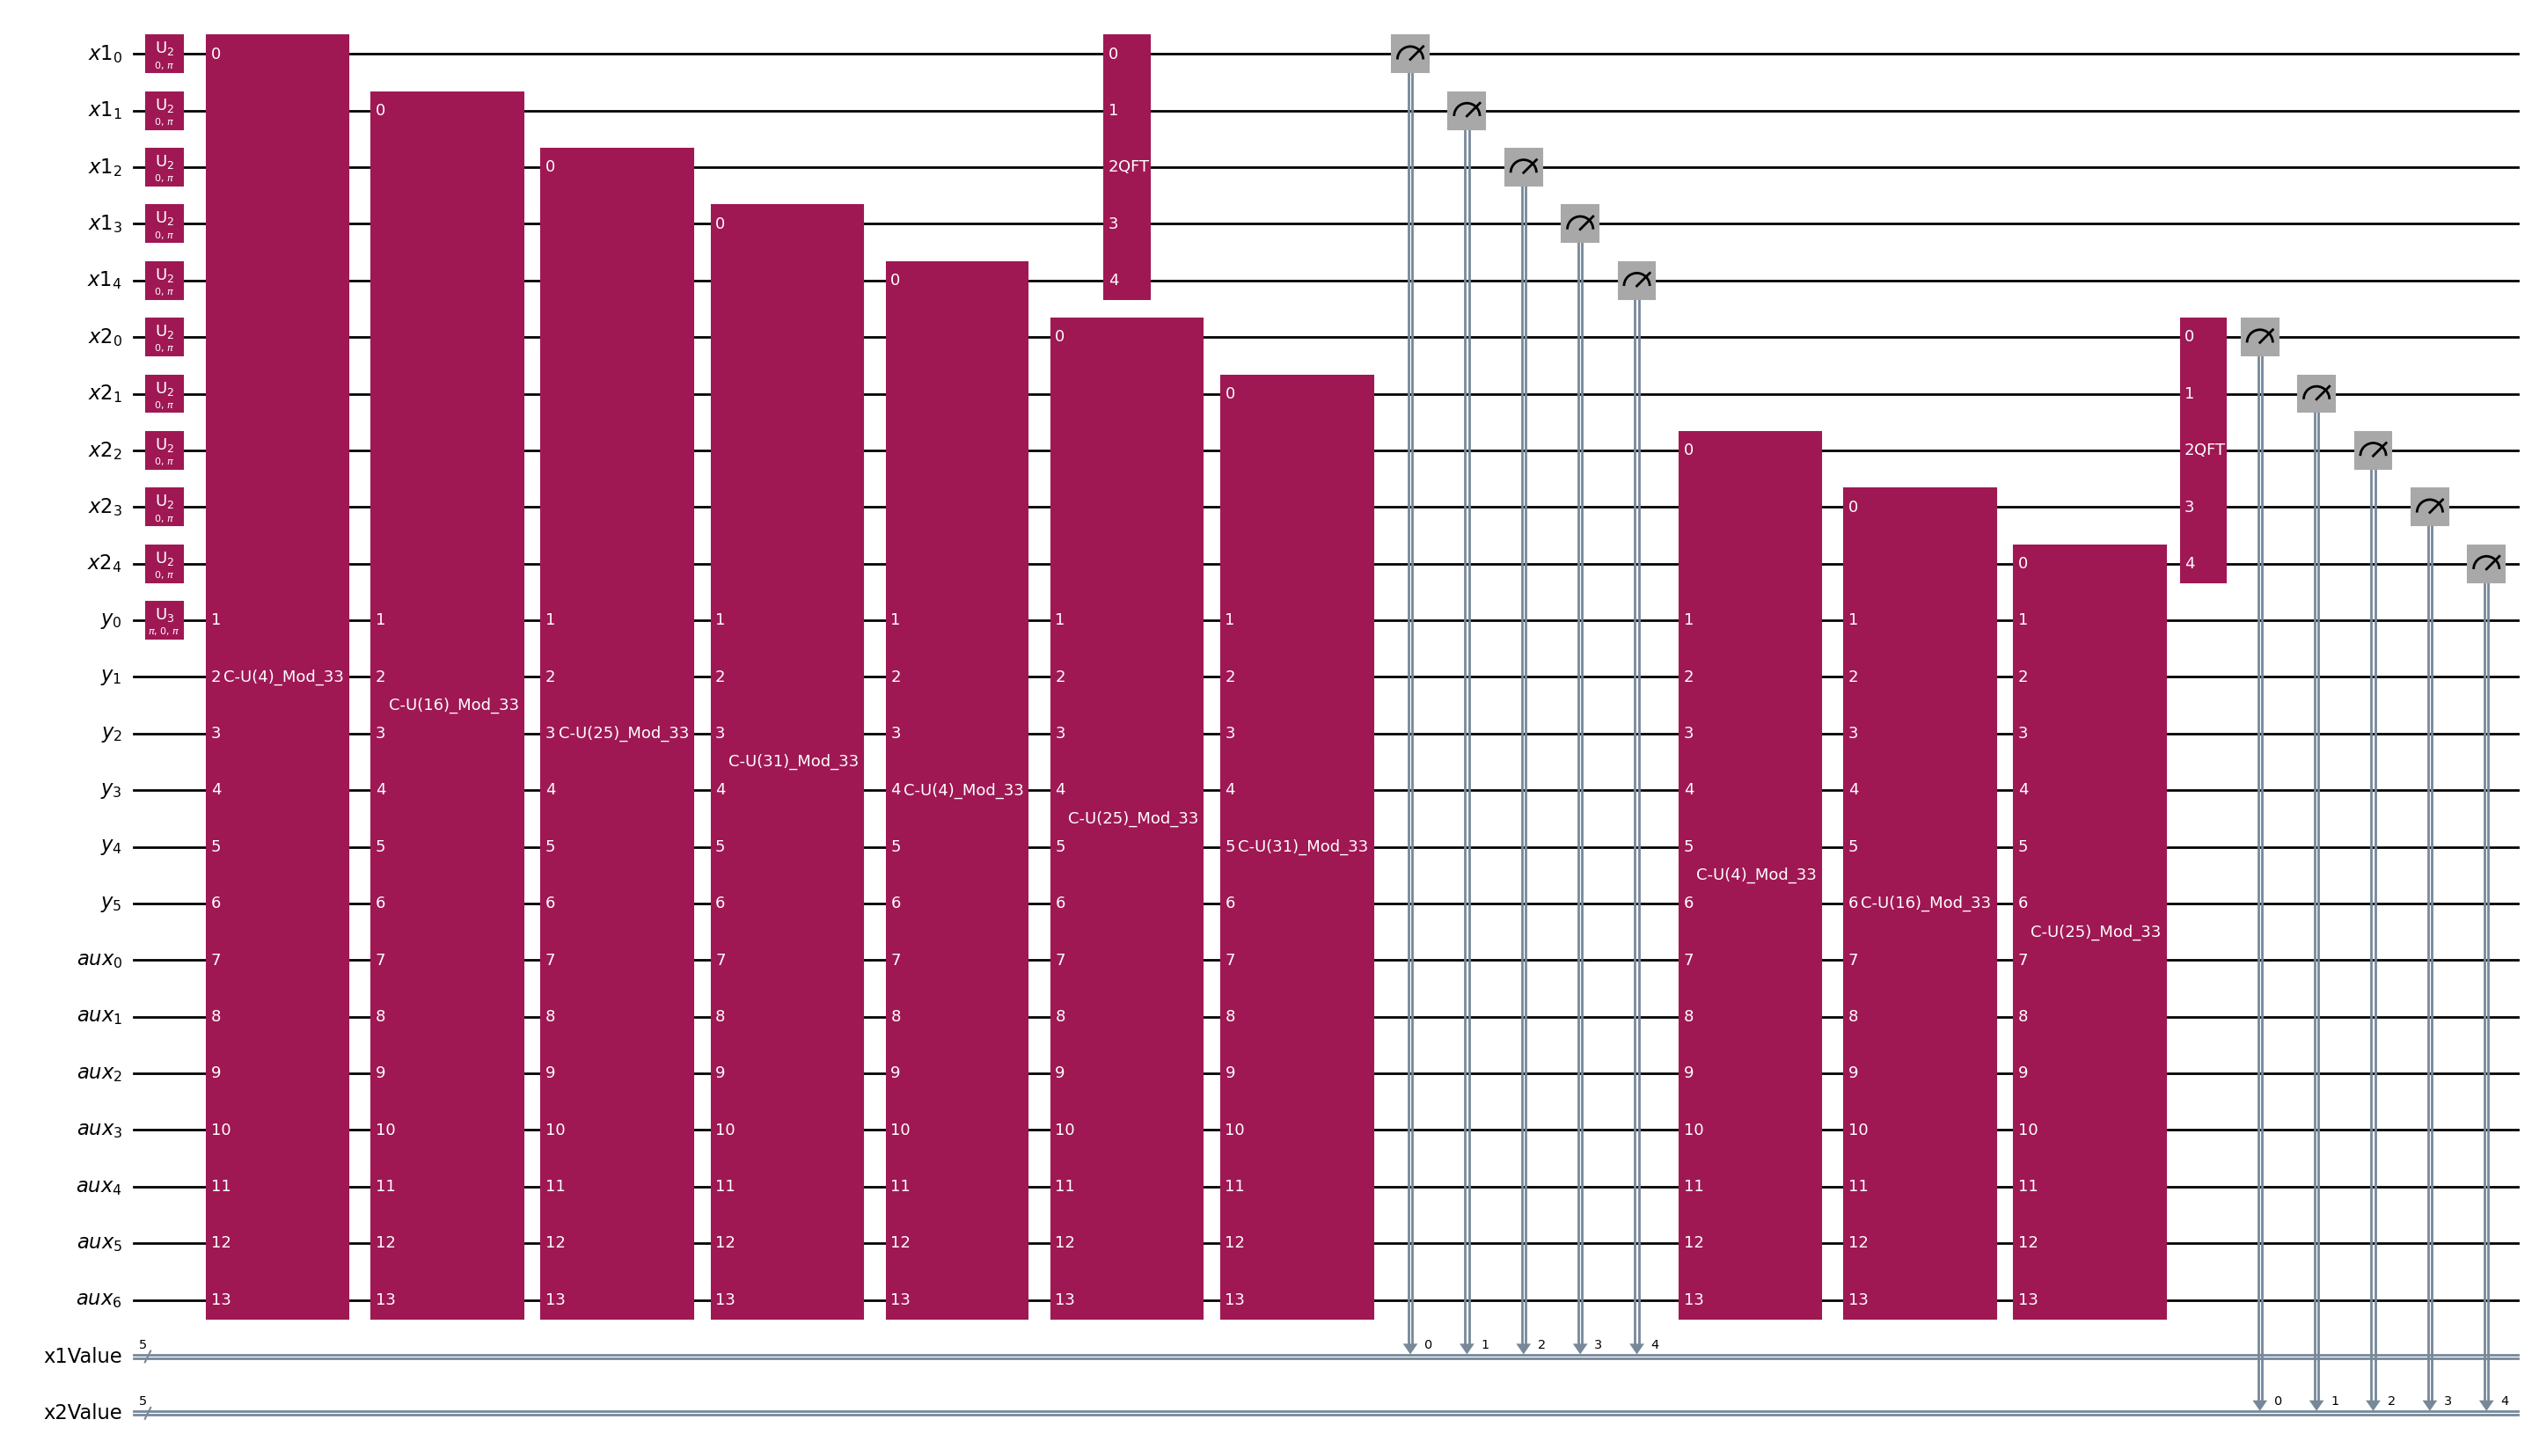

In [1]:
from implementations.r_haner import HanerRegev as Regev

N = 33

regev = Regev(shots=64)

d_ceil = False
qd_ceil = False

circuit = regev.construct_circuit(N, d_ceil, qd_ceil)
circuit.draw(output='mpl', fold=-1)
circuit.decompose().draw(output='mpl', fold=-1)

Select numbers to test.

In [3]:
# N = 15, 21; also 35, 55 (for these, simulation will be longer, up to few minutes)
N = 15
# 
# # 1 < a < N and gcd(a, N) = 1
# a = 7

## Classical calculations

Compute classically reminders of `a^x mod N` for `x = 1, ..., 20`. Present results on graph, observe the period. For modular power, see https://docs.python.org/3.8/library/functions.html#pow

In [4]:
exponents = list(range(20))
values = []

for i in exponents:
    value = pow(a, i, mod=N)
    values.append(value)

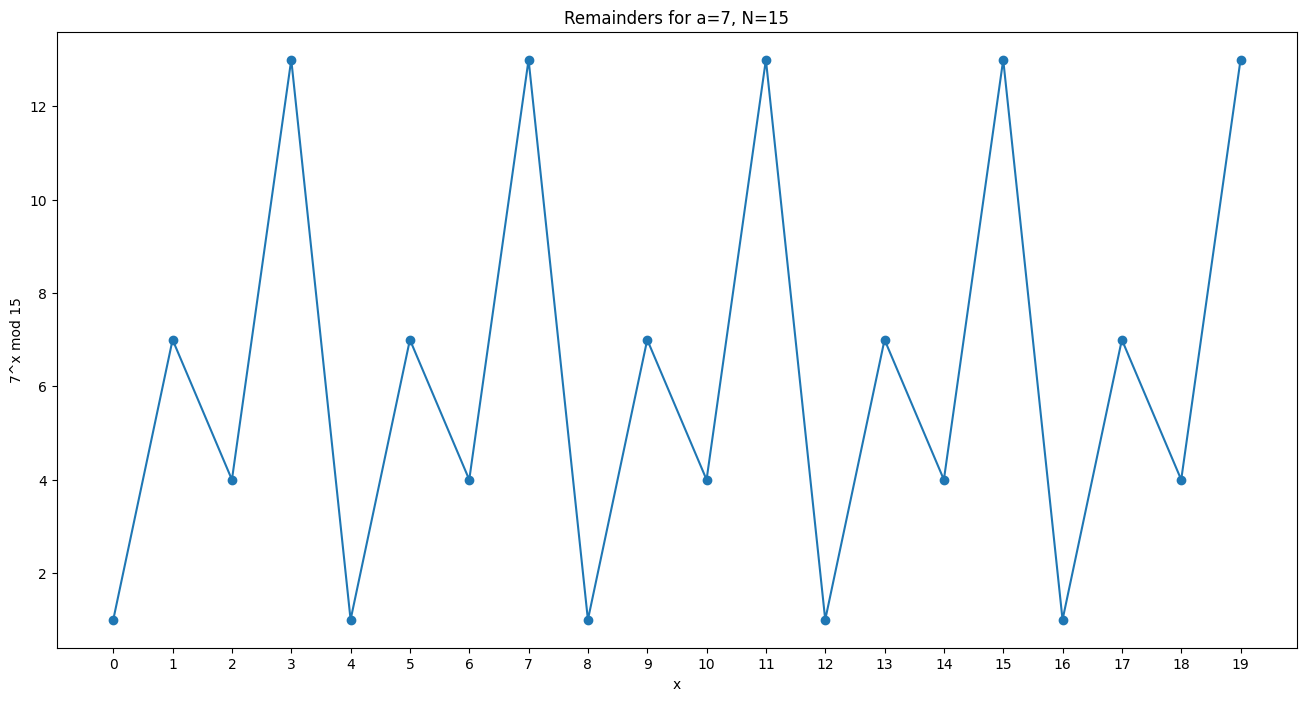

In [5]:
plt.figure(figsize=(16, 8))
plt.title(f'Remainders for a={a}, N={N}')
plt.xlabel('x')
plt.xticks(exponents)
plt.ylabel(f'{a}^x mod {N}')
plt.scatter(exponents, values)
plt.plot(exponents, values)
plt.show()

## Operation `a^x mod N` in Qiskit

Import gate for modular exponentiation. You can also use other implementations (mind the number of ancillary qubits).

In [6]:
from gates.mix.modular_exponentiation import modular_exponentiation_gate  # (n + 1 ancilla)

# from gates.takahashi.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla)

# from gates.beauregard.modular_exponentiation import modular_exponentiation_gate # (n + 2 ancilla)

# from gates.haner.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla, big size of circuit!)

Count width `n` of `N`.

In [7]:
n = N.bit_length()
print(n)

4


Create registers and circuit.

In [8]:
# input register
x_qreg = QuantumRegister(2 * n, name='x')

# output register, must contain 1
y_qreg = QuantumRegister(n, name='y')

In [9]:
# ancillary register; change the size according to selected implementation
ancillary_register_size = n + 1
aux_qreg = QuantumRegister(ancillary_register_size, name='aux')

In [10]:
circuit = QuantumCircuit(x_qreg, y_qreg, aux_qreg)

In [11]:
# prepare input register
circuit.h(x_qreg)

# prepare output register
circuit.x(y_qreg[0])

In [12]:
# append gate
gate = modular_exponentiation_gate(a, N, n)
circuit.append(gate, circuit.qubits)

In [13]:
# measure output register
y_creg = ClassicalRegister(n, name='yValue')
circuit.add_register(y_creg)
circuit.measure(y_qreg, y_creg)

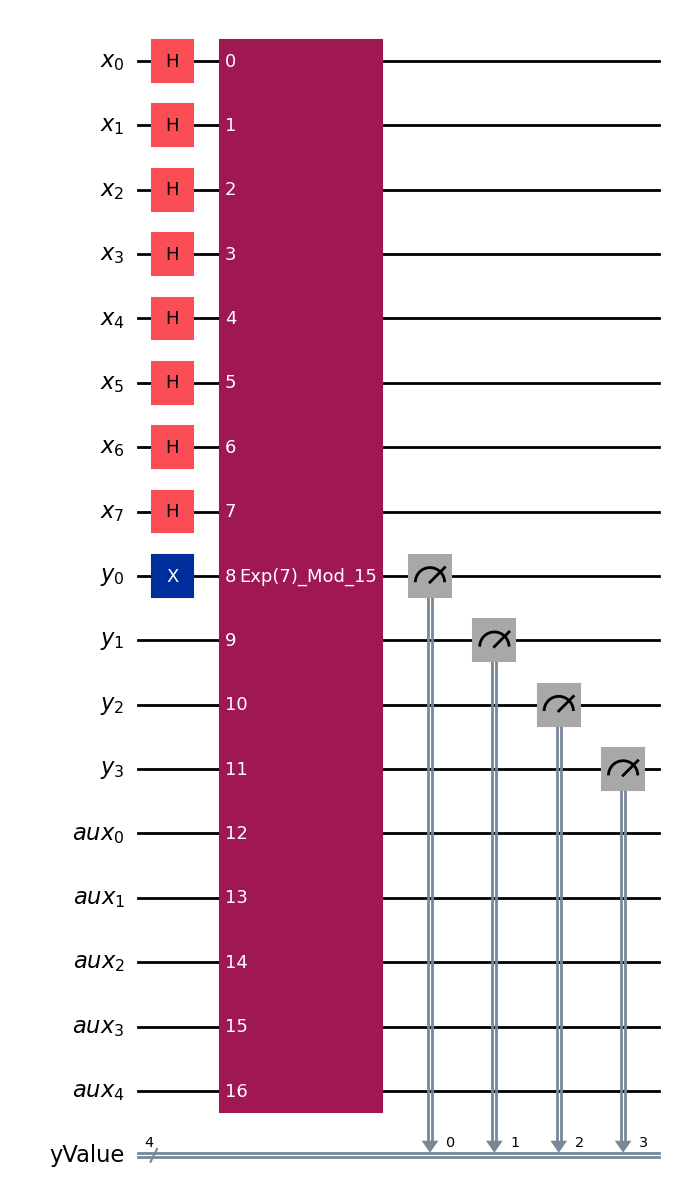

In [14]:
circuit.draw(output='mpl', fold=-1)

Run circuit using AerSimulator


In [15]:
import qiskit
from qiskit_aer import AerSimulator
# Zakomentowałem poniższą linijkę
# from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#Construct the simulator
aersim = AerSimulator()

In [16]:
pm = generate_preset_pass_manager(backend=aersim, optimization_level=3)
isa_qc = pm.run(circuit)
#run
result = aersim.run(isa_qc, shots=1024).result()
counts = result.get_counts(0)
print('Counts:', counts)

Counts: {'1101': 256, '0001': 254, '0111': 245, '0100': 269}


Draw histogram. Compare results with classical calculations.

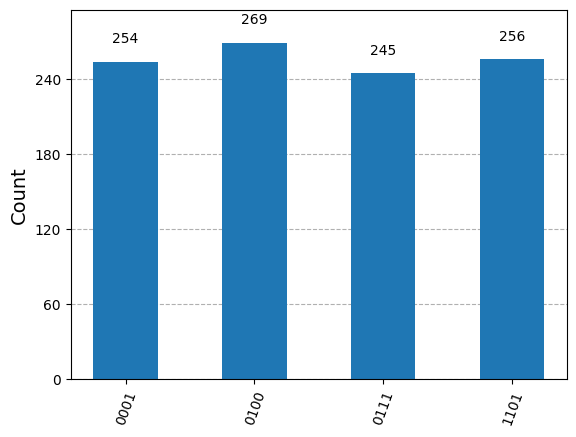

In [17]:
#counts = exponentiation_result.quasi_dists[0].binary_probabilities()
plot_histogram(counts)

Let's try observe period.

In [18]:
# clone circuit
circuit2 = circuit.copy()

# measure input register
x_creg = ClassicalRegister(2 * n, name='xValue')
circuit2.add_register(x_creg)
circuit2.measure(x_qreg, x_creg)

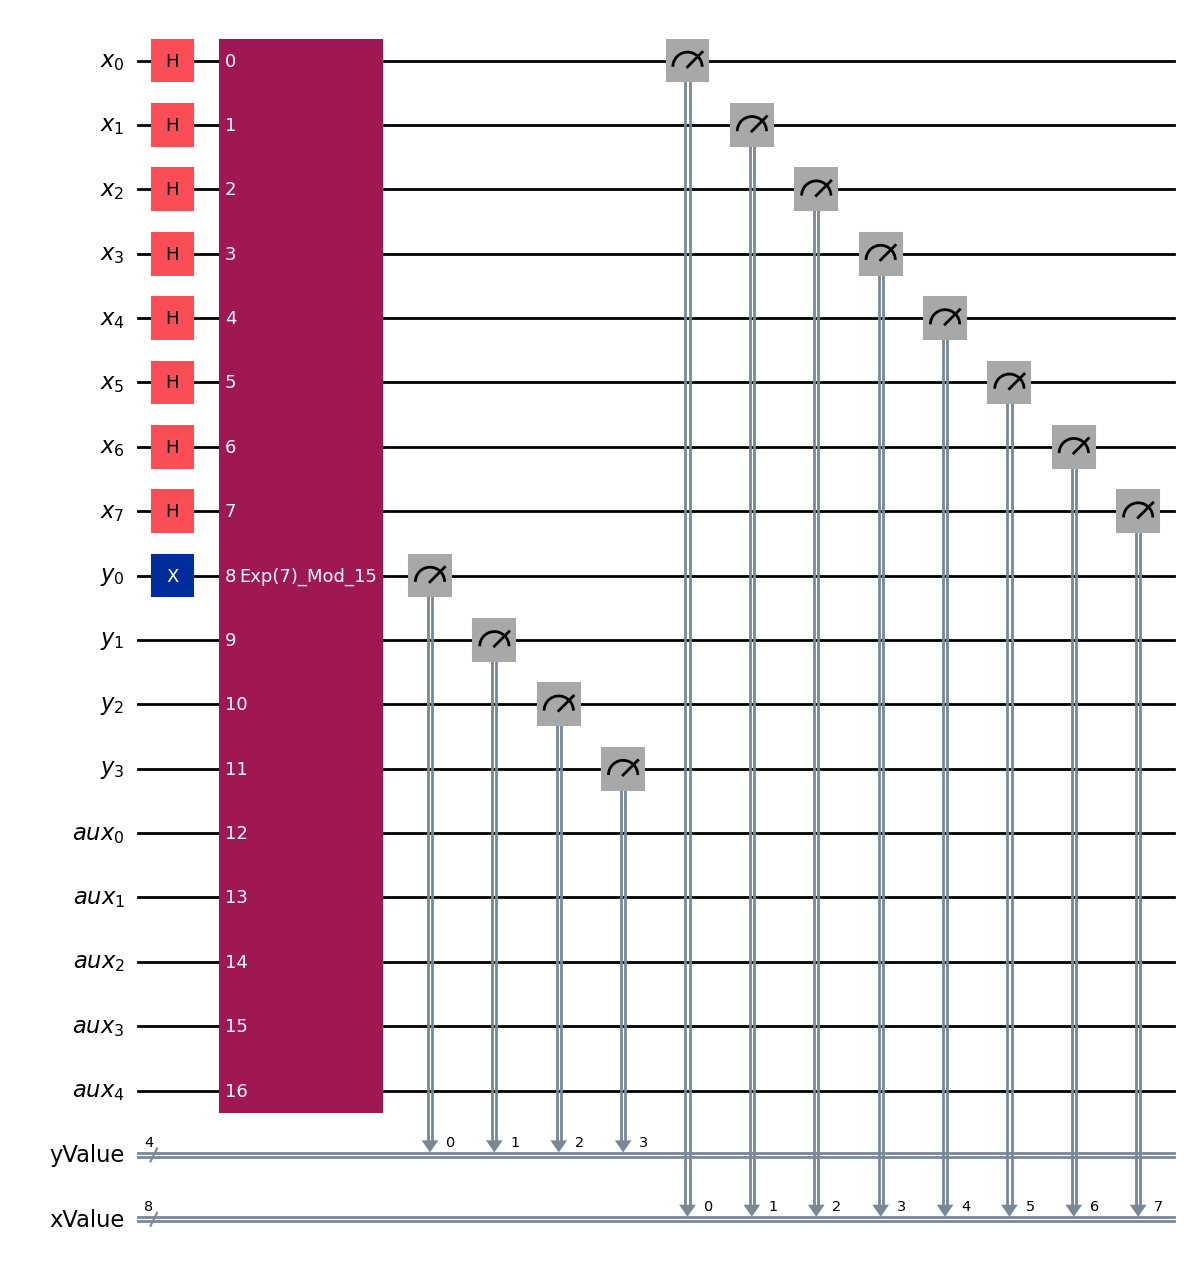

In [19]:
circuit2.draw(output='mpl', fold=-1)

In [20]:
pm = generate_preset_pass_manager(backend=aersim, optimization_level=3)
isa_qc = pm.run(circuit2)
result = aersim.run(isa_qc,shots=1024).result()
counts = result.get_counts(0)

In [21]:
values_map = {}
for measurement in counts.keys():
    s=2*n
    x=int(measurement[:s], base=2)
    y=int(measurement[s:], base=2)
    values = values_map.get(y, [])
    values.append(x)
    values_map[y] = values

Print measured `x` values for each exponentiation result.
You should observe that values differs from each other by constant - period `r`. (precisely, only part of them
in different runs will - think why!)

In [22]:
for y, x_values in values_map.items():
    print(y)
    print(sorted(x_values))
    print()

1
[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 252]

4
[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 154, 158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198, 202, 206, 210, 214, 218, 222, 226, 230, 234, 238, 242, 246, 250, 254]

7
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253]

13
[3, 7, 11, 19, 23, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 12

## Debugging 2


In [1]:
from implementations.r_haner import HanerRegev as Regev
# create instance of class
regev = Regev(shots=128)

N=33 
# circuit = regev.construct_circuit(N, semi_classical=False, measurement=True)
# circuit.draw(output='mpl', fold=-1)



In [2]:
result = regev.get_vector(N, semi_classical=False)

ceil_floor
N: 33
n: 6
d: 3
qd: 5
We are very lucky! Here is p: 3 and q: 11
a: [4, 25, 49]


counts.items(): dict_items([('11010 10011 01110', 1), ('10101 00110 11010', 1), ('01101 11010 00100', 1), ('01101 11010 01011', 1), ('00111 01101 01011', 1), ('10100 00111 11010', 1), ('11001 10010 01101', 1), ('00101 11101 10011', 1), ('00011 01101 10011', 1), ('10011 00101 11000', 1), ('01101 11010 00001', 1), ('10011 00111 11001', 1), ('10011 00111 11010', 4), ('11001 10011 01101', 4), ('01100 11010 00110', 2), ('01101 11010 00110', 8), ('10011 00010 11010', 1), ('00110 01101 10010', 2), ('10011 00111 10101', 1), ('00110 01101 10100', 2), ('10011 00110 11001', 4), ('00101 01101 10011', 4), ('11010 10100 01101', 1), ('10011 00111 10000', 1), ('01110 11001 00111', 1), ('01101 11001 00110', 2), ('11010 10011 01101', 11), ('10000 00110 11001', 1), ('10011 00110 11010', 7), ('01101 10111 00110', 1), ('00000 00000 00000', 31), ('11010 10011 01100', 2), ('01110 11011 00110', 1), ('00111 01101 10011'

In [3]:
print(result.total_shots, result.successful_shots)
print(result.total_counts, result.successful_counts)
print(result.order)
print(result)

128 128
42 42
None


## Finding period / order in Qiskit

Import Shor's algorithm implementation.
Similarly to modular exponentiation gate, you can test different implementations.

In [1]:
# from implementations.mix import MixShor as Shor

# from implementations.takahashi import TakahashiShor as Shor

# from implementations.beauregard import BeauregardShor as Shor

# from implementations.haner import HanerShor as Shor # (big size of circuit!)

from implementations.r_haner import HanerRegev as Regev

For usage, class instance have to be created. The circuits will be run using local qiskit-air simulator.

In [2]:
# create instance of class
regev = Regev(shots=64)

Observe 3 parts of algorithm.

N: 15
n: 4
d: 2
qd: 4
We are very lucky! Here is p: 3 and q: 5.0
We are very lucky! Here is p: 5 and q: 3.0
a: [4, 49]



qubits_to_pass: [Qubit(QuantumRegister(4, 'x1'), 0), Qubit(QuantumRegister(4, 'x1'), 1), Qubit(QuantumRegister(4, 'x1'), 2), Qubit(QuantumRegister(4, 'x1'), 3), Qubit(QuantumRegister(4, 'y'), 0), Qubit(QuantumRegister(4, 'y'), 1), Qubit(QuantumRegister(4, 'y'), 2), Qubit(QuantumRegister(4, 'y'), 3), AncillaQubit(AncillaRegister(5, 'aux'), 0), AncillaQubit(AncillaRegister(5, 'aux'), 1), AncillaQubit(AncillaRegister(5, 'aux'), 2), AncillaQubit(AncillaRegister(5, 'aux'), 3), AncillaQubit(AncillaRegister(5, 'aux'), 4)]
a_to_pass: 4


qubits_to_pass: [Qubit(QuantumRegister(4, 'x2'), 0), Qubit(QuantumRegister(4, 'x2'), 1), Qubit(QuantumRegister(4, 'x2'), 2), Qubit(QuantumRegister(4, 'x2'), 3), Qubit(QuantumRegister(4, 'y'), 0), Qubit(QuantumRegister(4, 'y'), 1), Qubit(QuantumRegister(4, 'y'), 2), Qubit(QuantumRegister(4, 'y'), 3), AncillaQubit(AncillaRegister(5, 'aux'), 0

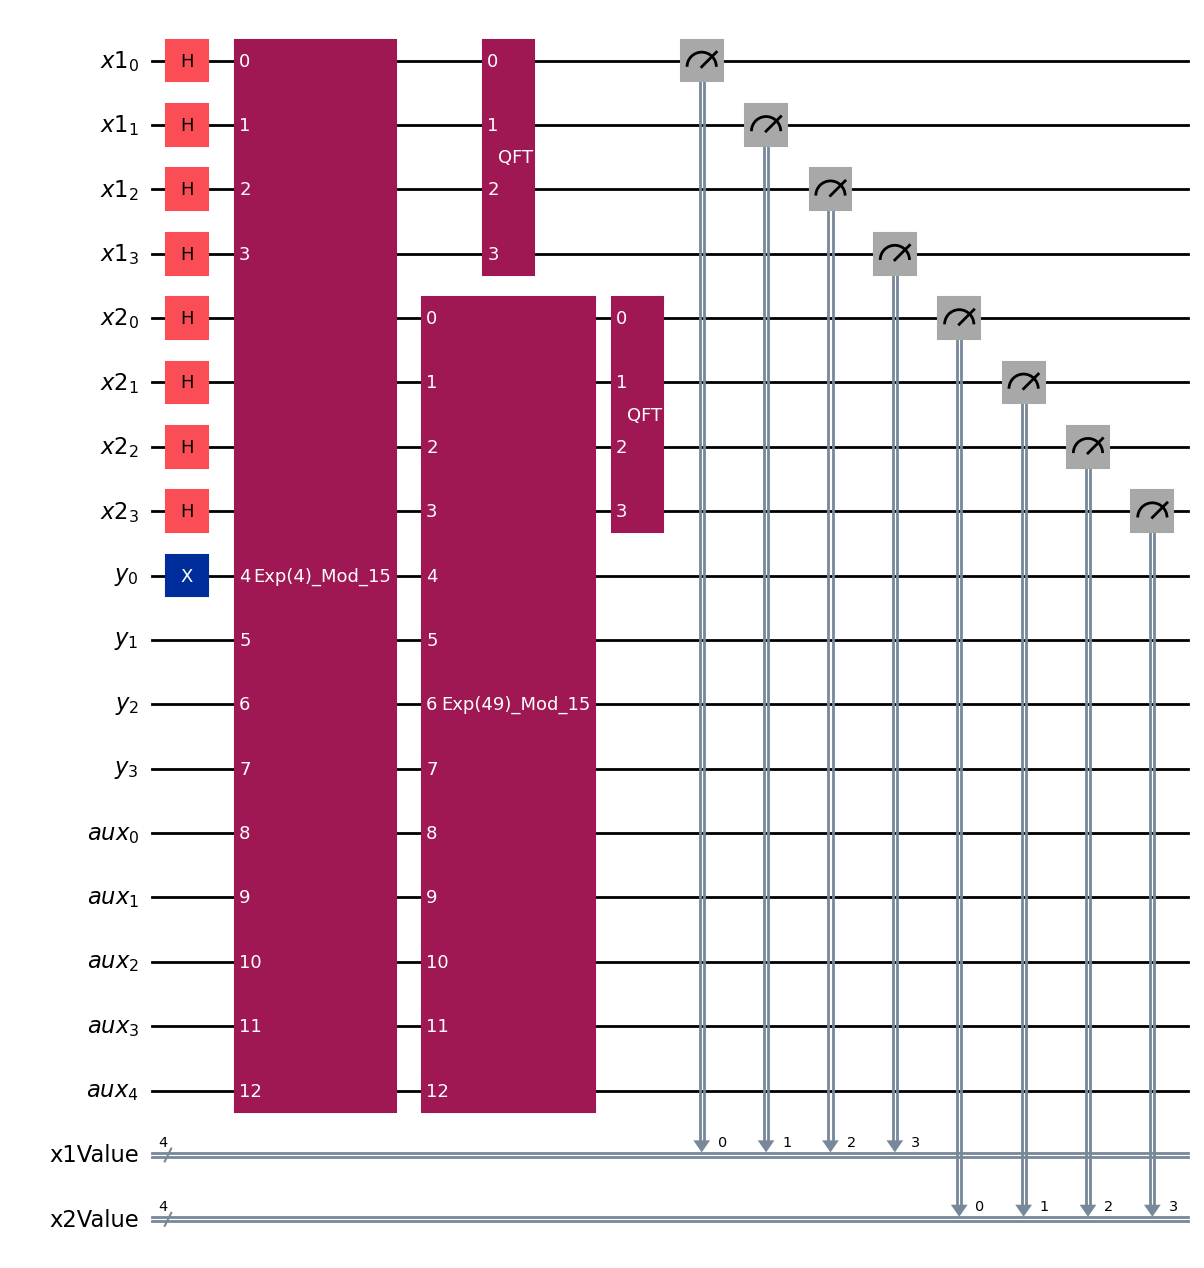

In [3]:
N=15
circuit = regev.construct_circuit(N, semi_classical=False, measurement=True)
circuit.draw(output='mpl', fold=-1)

Invoke `get_order()` to run algorithm and post-process measurements. 
<b>Setting `semi_classical` argument to `True` will run algorithm on optimized version of circuit.</b>

In [4]:
result = regev.get_vector(N, semi_classical=False)

N: 15
n: 4
d: 2
qd: 4
We are very lucky! Here is p: 3 and q: 5.0
We are very lucky! Here is p: 5 and q: 3.0
a: [4, 49]



qubits_to_pass: [Qubit(QuantumRegister(4, 'x1'), 0), Qubit(QuantumRegister(4, 'x1'), 1), Qubit(QuantumRegister(4, 'x1'), 2), Qubit(QuantumRegister(4, 'x1'), 3), Qubit(QuantumRegister(4, 'y'), 0), Qubit(QuantumRegister(4, 'y'), 1), Qubit(QuantumRegister(4, 'y'), 2), Qubit(QuantumRegister(4, 'y'), 3), AncillaQubit(AncillaRegister(5, 'aux'), 0), AncillaQubit(AncillaRegister(5, 'aux'), 1), AncillaQubit(AncillaRegister(5, 'aux'), 2), AncillaQubit(AncillaRegister(5, 'aux'), 3), AncillaQubit(AncillaRegister(5, 'aux'), 4)]
a_to_pass: 4


qubits_to_pass: [Qubit(QuantumRegister(4, 'x2'), 0), Qubit(QuantumRegister(4, 'x2'), 1), Qubit(QuantumRegister(4, 'x2'), 2), Qubit(QuantumRegister(4, 'x2'), 3), Qubit(QuantumRegister(4, 'y'), 0), Qubit(QuantumRegister(4, 'y'), 1), Qubit(QuantumRegister(4, 'y'), 2), Qubit(QuantumRegister(4, 'y'), 3), AncillaQubit(AncillaRegister(5, 'aux'), 0

ValueError: invalid literal for int() with base 2: '0000 0000'

Print result. Compare it with earlier observed order.

In [5]:
print(result.total_shots, result.successful_shots)
print(result.total_counts, result.successful_counts)
print(result.order)

NameError: name 'result' is not defined

## Bob's and Eva's algorithm

Use `get_order()` to perform tasks from laboratories.
For modular power and modular inverse see: https://docs.python.org/3/library/functions.html#pow

In [ ]:
# TODO by you :)

In [ ]:
import qiskit
qiskit.version.get_version_info()

In [ ]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()